## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# Plotting Style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## Load Data & Initial Exploration

Training data shape: (1460, 81)
Test data shape: (1459, 80)
Training samples: 1460
Test samples: 1459
Total features: 80

First 5 rows:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl 

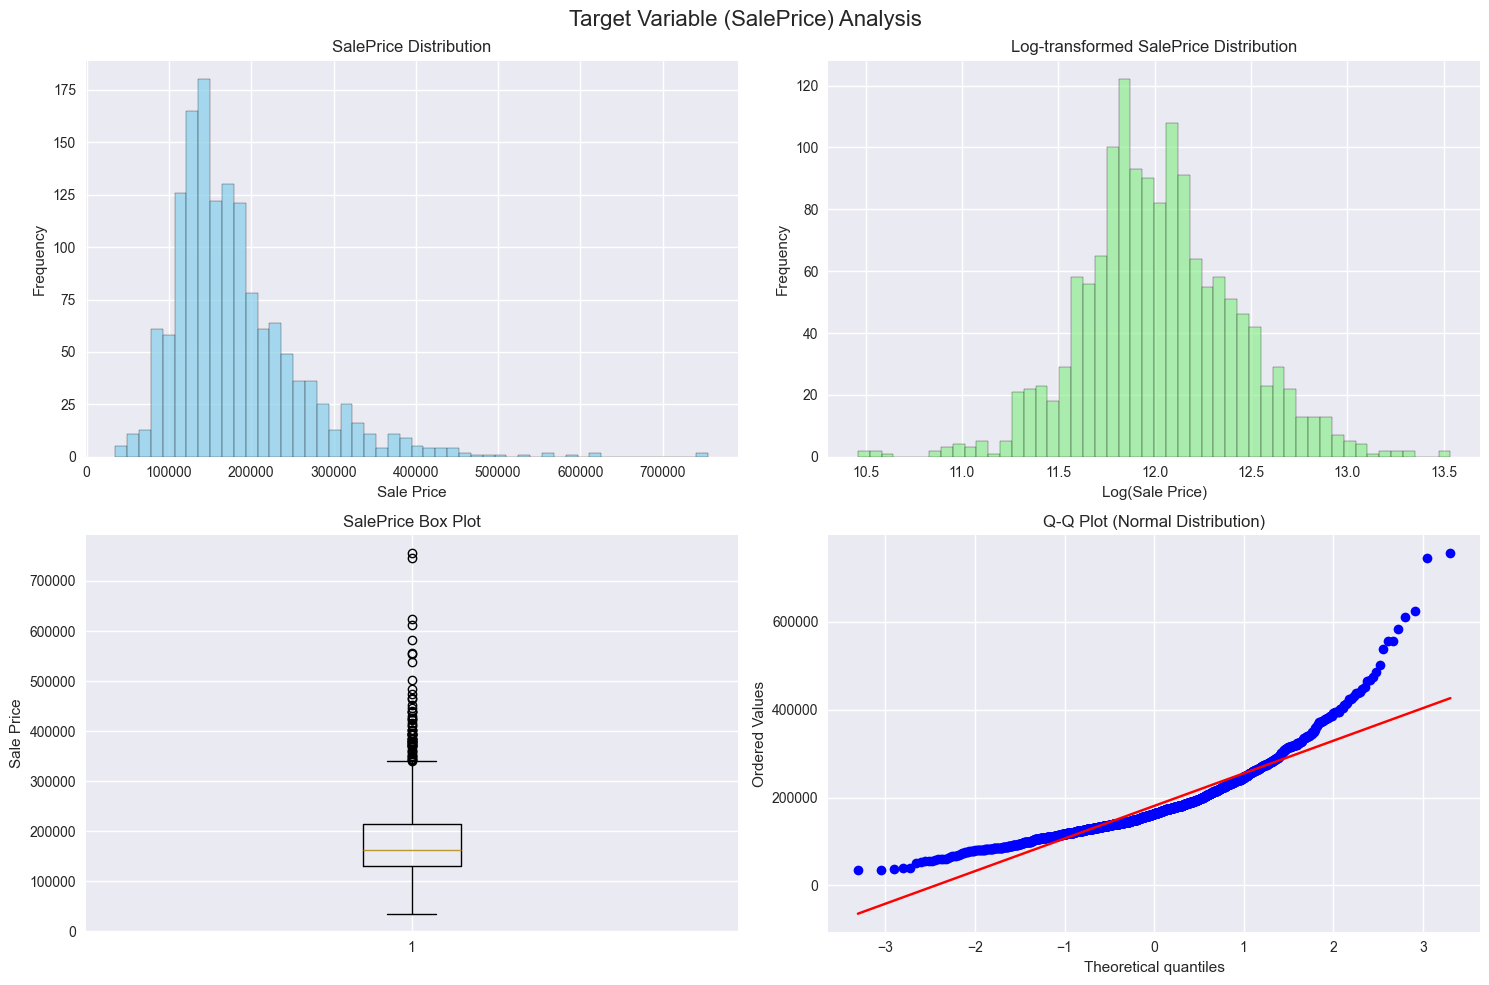

In [2]:
# Load the datasets
train_df = pd.read_csv('D:\\python_progs\\Celebal_codes\\week5\\house-prices-advanced-regression-techniques\\train.csv')
test_df = pd.read_csv('D:\\python_progs\\Celebal_codes\\week5\\house-prices-advanced-regression-techniques\\test.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Total features: {len(train_df.columns) - 1}")

print("\nFirst 5 rows:")
print(train_df.head())

# Target variable analysis
print(f"\nSalePrice statistics:")
print(train_df['SalePrice'].describe())
print(f"\nSkewness: {train_df['SalePrice'].skew():.4f}")
print(f"Kurtosis: {train_df['SalePrice'].kurtosis():.4f}")

# Visualizations of SalePrice
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Target Variable (SalePrice) Analysis', fontsize=16)

axes[0, 0].hist(train_df['SalePrice'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('SalePrice Distribution')
axes[0, 0].set_xlabel('Sale Price')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(np.log1p(train_df['SalePrice']), bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Log-transformed SalePrice Distribution')
axes[0, 1].set_xlabel('Log(Sale Price)')
axes[0, 1].set_ylabel('Frequency')

axes[1, 0].boxplot(train_df['SalePrice'])
axes[1, 0].set_title('SalePrice Box Plot')
axes[1, 0].set_ylabel('Sale Price')

stats.probplot(train_df['SalePrice'], dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Normal Distribution)')

plt.tight_layout()
plt.show()


## Combine Data & Missing Value Analysis

Total columns: 82
Sample columns: ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt']
Porch/Deck related columns: ['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
Features with missing values: 35

Top 20 features with missing values:
PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageYrBlt      159
GarageFinish     159
GarageQual       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
dtype: int64


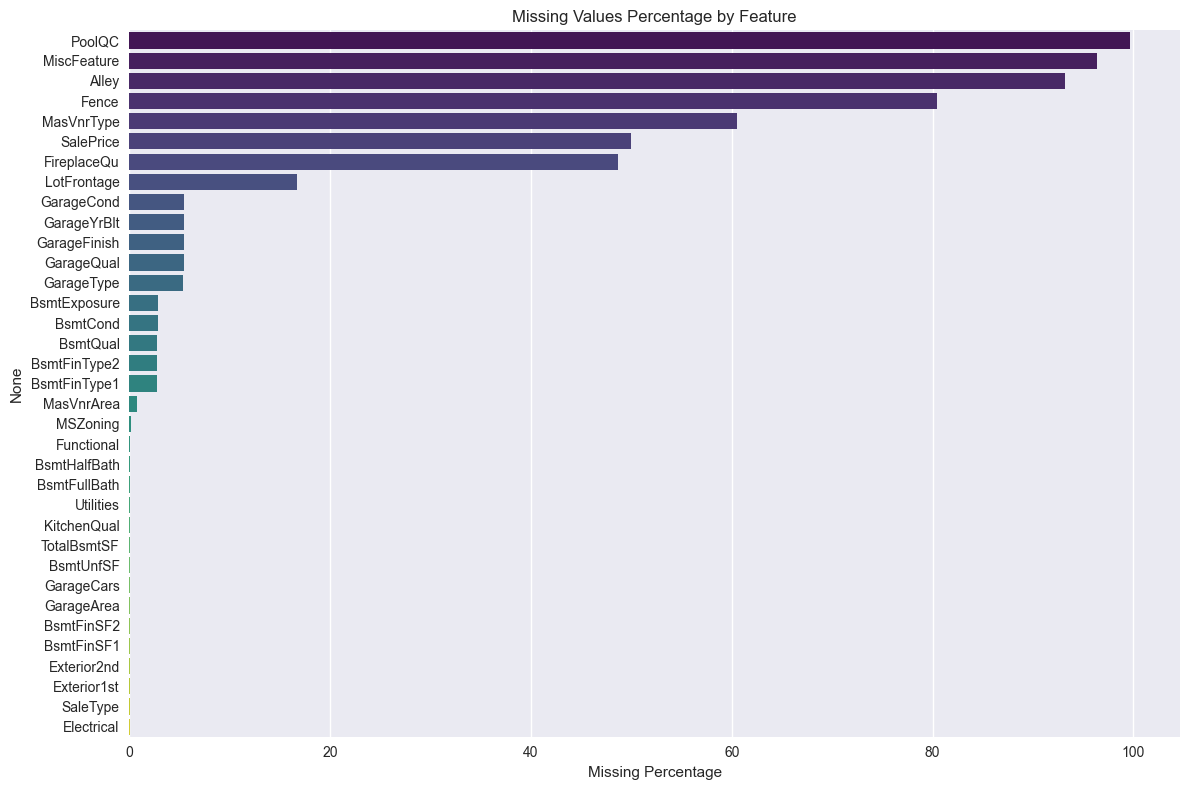

Numeric features: 36
Categorical features: 43


In [3]:
# Add source identifier
train_df['dataset'] = 'train'
test_df['dataset'] = 'test'
test_df['SalePrice'] = np.nan

# Combine
all_data = pd.concat([train_df, test_df], ignore_index=True)

# Check porch columns
print(f"Total columns: {len(all_data.columns)}")
print("Sample columns:", all_data.columns[:20].tolist())
porch_cols = [col for col in all_data.columns if 'Porch' in col or 'Deck' in col]
print(f"Porch/Deck related columns: {porch_cols}")

# Missing values
missing_data = all_data.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
print(f"Features with missing values: {len(missing_data)}")
print("\nTop 20 features with missing values:")
print(missing_data.head(20))

# Visualize
plt.figure(figsize=(12, 8))
missing_percent = (missing_data / len(all_data)) * 100
sns.barplot(x=missing_percent.values, y=missing_percent.index, palette='viridis')
plt.title('Missing Values Percentage by Feature')
plt.xlabel('Missing Percentage')
plt.tight_layout()
plt.show()

# Feature types
numeric_features = all_data.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = all_data.select_dtypes(include=['object']).columns.tolist()
numeric_features.remove('SalePrice')
numeric_features.remove('Id')
categorical_features.remove('dataset')
print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")


## Preprocessing & Feature Engineering

In [4]:
# Copy for preprocessing
data = all_data.copy()

# Missing value handling
none_features = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                'PoolQC', 'Fence', 'MiscFeature']
for feature in none_features:
    if feature in data.columns:
        data[feature] = data[feature].fillna('None')

garage_features = ['GarageYrBlt', 'GarageArea', 'GarageCars']
for feature in garage_features:
    if feature in data.columns:
        data[feature] = data[feature].fillna(0)

basement_features = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
for feature in basement_features:
    if feature in data.columns:
        data[feature] = data[feature].fillna(0)

categorical_mode_features = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
                           'Electrical', 'KitchenQual', 'Functional', 'SaleType']
for feature in categorical_mode_features:
    if feature in data.columns:
        data[feature] = data[feature].fillna(data[feature].mode()[0])

numeric_median_features = ['LotFrontage', 'MasVnrArea']
for feature in numeric_median_features:
    if feature in data.columns:
        data[feature] = data[feature].fillna(data[feature].median())

remaining_missing = data.isnull().sum()
remaining_missing = remaining_missing[remaining_missing > 0]
print(f"Remaining missing values: {len(remaining_missing)}")

# Feature engineering
sf_columns = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF']
available_sf_cols = [col for col in sf_columns if col in data.columns]
data['TotalSF'] = data[available_sf_cols].sum(axis=1) if available_sf_cols else 0

bath_columns = ['FullBath', 'BsmtFullBath', 'HalfBath', 'BsmtHalfBath']
if all(col in data.columns for col in ['FullBath', 'BsmtFullBath']):
    data['TotalBath'] = data['FullBath'] + data['BsmtFullBath']
    if 'HalfBath' in data.columns:
        data['TotalBath'] += 0.5 * data['HalfBath']
    if 'BsmtHalfBath' in data.columns:
        data['TotalBath'] += 0.5 * data['BsmtHalfBath']
else:
    data['TotalBath'] = 0

porch_columns = ['OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch', 'WoodDeckSF']
data['TotalPorchSF'] = data[porch_columns].sum(axis=1) if porch_columns else 0
data['HouseAge'] = data['YrSold'] - data['YearBuilt']
data['RemodAge'] = data['YrSold'] - data['YearRemodAdd']
data['GarageAge'] = (data['YrSold'] - data['GarageYrBlt']).fillna(0)

# Ordinal mapping
qual_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}
data['OverallQualCond'] = data['OverallQual'] + data['OverallCond']

quality_features = ['BsmtQual', 'BsmtCond', 'FireplaceQu', 'GarageQual', 'GarageCond', 'KitchenQual']
for feature in quality_features:
    data[feature] = data[feature].map(qual_map).fillna(0)

data['BsmtExposure'] = data['BsmtExposure'].map({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0}).fillna(0)
bsmt_map = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0}
data['BsmtFinType1'] = data['BsmtFinType1'].map(bsmt_map).fillna(0)
data['BsmtFinType2'] = data['BsmtFinType2'].map(bsmt_map).fillna(0)
data['GarageFinish'] = data['GarageFinish'].map({'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0}).fillna(0)

# Skewed features
numeric_feats = data.dtypes[data.dtypes != "object"].index
skewness = data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
high_skew = skewness[abs(skewness) > 0.75]
for feature in high_skew.index:
    if feature != 'SalePrice':
        data[feature] = np.log1p(data[feature])

# Encode categorical features
label_encoders = {}
categorical_features_remaining = data.select_dtypes(include=['object']).columns.tolist()
categorical_features_remaining.remove('dataset')

for feature in categorical_features_remaining:
    le = LabelEncoder()
    data[feature] = le.fit_transform(data[feature].astype(str))
    label_encoders[feature] = le


Remaining missing values: 1


## Correlation Analysis & Feature Selection

Top 15 features correlated with SalePrice:
SalePrice          1.000000
OverallQual        0.790982
TotalSF            0.761613
GrLivArea          0.695147
KitchenQual        0.659600
GarageCars         0.640409
TotalBath          0.631731
GarageArea         0.623431
OverallQualCond    0.594786
1stFlrSF           0.591299
FullBath           0.560664
GarageFinish       0.549247
YearBuilt          0.522897
TotRmsAbvGrd       0.522355
FireplaceQu        0.520438
Name: SalePrice, dtype: float64


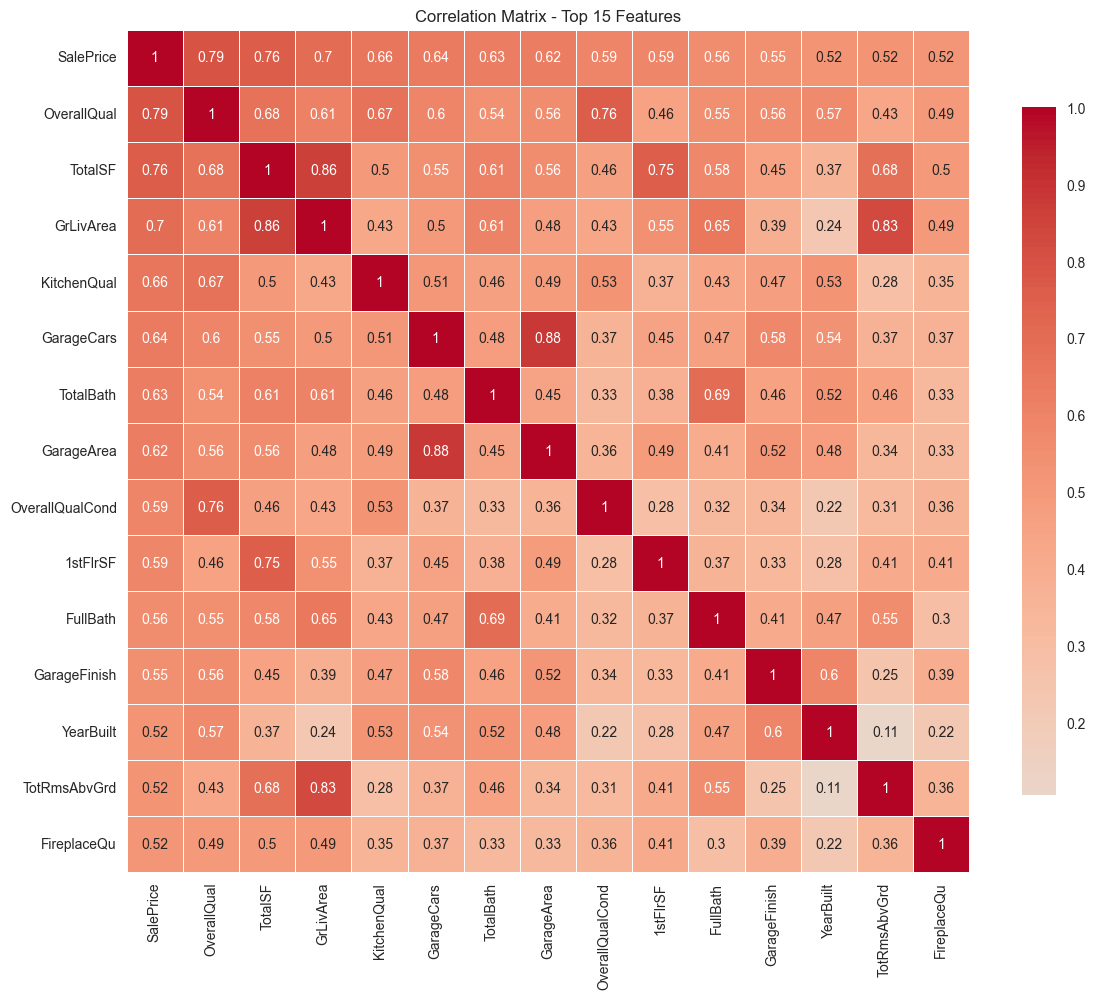

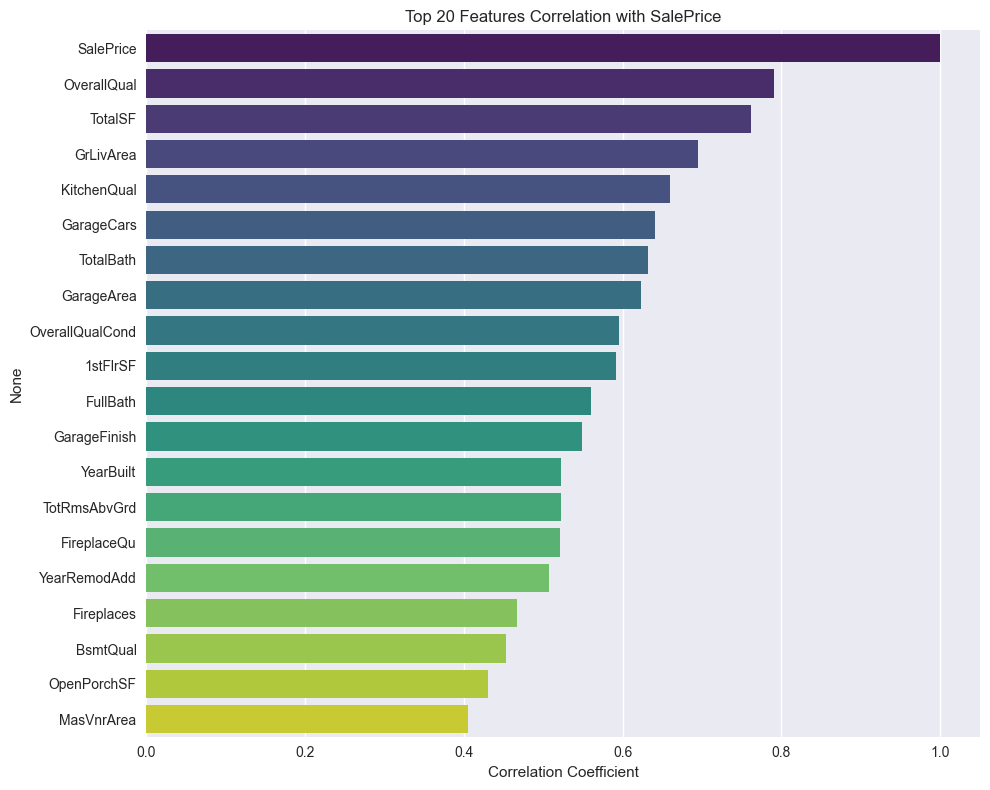

In [5]:
# Split back into train and test sets
train_data = data[data['dataset'] == 'train'].copy()
test_data = data[data['dataset'] == 'test'].copy()

train_data = train_data.drop(['dataset'], axis=1)
test_data = test_data.drop(['dataset', 'SalePrice'], axis=1)

# Correlation with SalePrice
correlations = train_data.corr()['SalePrice'].sort_values(ascending=False)

print("Top 15 features correlated with SalePrice:")
print(correlations.head(15))

# Heatmap of top correlated features
plt.figure(figsize=(12, 10))
top_features = correlations.head(15).index.tolist()
correlation_matrix = train_data[top_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix - Top 15 Features')
plt.tight_layout()
plt.show()

# Bar plot
plt.figure(figsize=(10, 8))
top_corr = correlations.head(20)
sns.barplot(x=top_corr.values, y=top_corr.index, palette='viridis')
plt.title('Top 20 Features Correlation with SalePrice')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()


## Modeling and Evaluation


Linear Regression Results:
Validation RMSE: 0.1458
Validation MAE: 0.0963
Validation R²: 0.8860
Cross-validation RMSE: 0.1363

Ridge Results:
Validation RMSE: 0.1440
Validation MAE: 0.0958
Validation R²: 0.8888
Cross-validation RMSE: 0.1358

Lasso Results:
Validation RMSE: 0.1382
Validation MAE: 0.0937
Validation R²: 0.8977
Cross-validation RMSE: 0.1350

Random Forest Results:
Validation RMSE: 0.1436
Validation MAE: 0.0943
Validation R²: 0.8895
Cross-validation RMSE: 0.1406

XGBoost Results:
Validation RMSE: 0.1467
Validation MAE: 0.0955
Validation R²: 0.8846
Cross-validation RMSE: 0.1402

LightGBM Results:
Validation RMSE: 0.1388
Validation MAE: 0.0894
Validation R²: 0.8968
Cross-validation RMSE: 0.1334

CatBoost Results:
Validation RMSE: 0.1415
Validation MAE: 0.0930
Validation R²: 0.8927
Cross-validation RMSE: 0.1292
               Model  Validation RMSE   CV RMSE
6           CatBoost         0.141526  0.129202
5           LightGBM         0.138761  0.133419
2              Lasso   

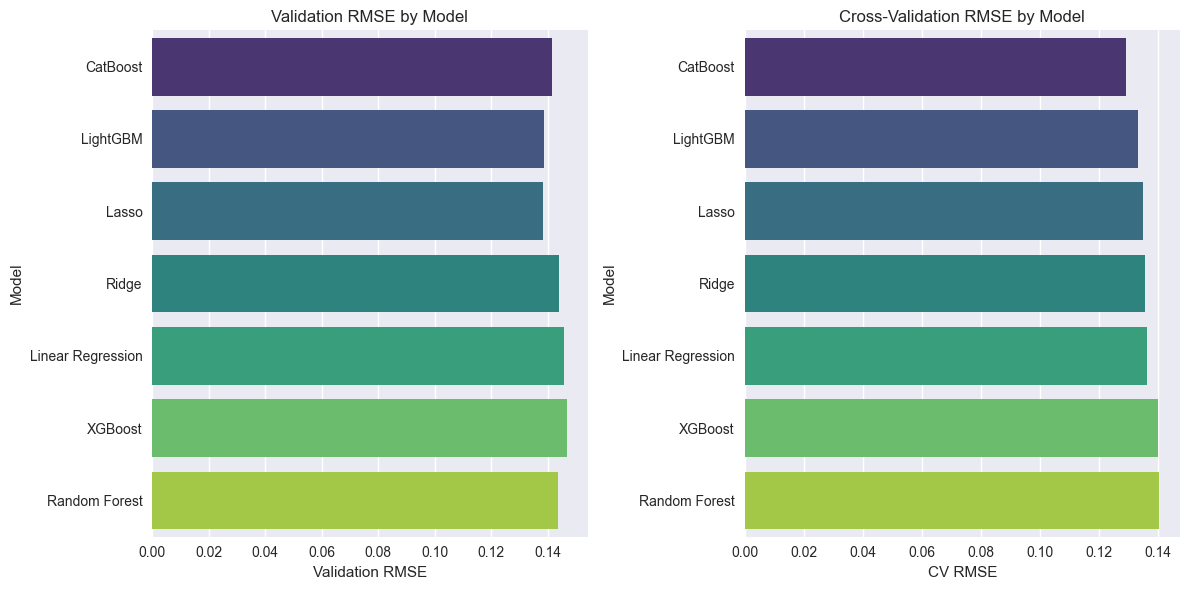

In [6]:
# Prepare features and target
X = train_data.drop(['SalePrice', 'Id'], axis=1)
y = train_data['SalePrice']
y_log = np.log1p(y)

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Scale numeric features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    cv_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())
    
    print(f"\n{model_name} Results:")
    print(f"Validation RMSE: {rmse:.4f}")
    print(f"Validation MAE: {mae:.4f}")
    print(f"Validation R²: {r2:.4f}")
    print(f"Cross-validation RMSE: {cv_rmse:.4f}")
    
    return model, rmse, cv_rmse

# Train models
models = {}
results = {}

model, rmse, cv_rmse = evaluate_model(LinearRegression(), X_train_scaled, y_train, X_val_scaled, y_val, 'Linear Regression')
models['Linear Regression'] = model
results['Linear Regression'] = (rmse, cv_rmse)

model, rmse, cv_rmse = evaluate_model(Ridge(alpha=1.0), X_train_scaled, y_train, X_val_scaled, y_val, 'Ridge')
models['Ridge'] = model
results['Ridge'] = (rmse, cv_rmse)

model, rmse, cv_rmse = evaluate_model(Lasso(alpha=0.001), X_train_scaled, y_train, X_val_scaled, y_val, 'Lasso')
models['Lasso'] = model
results['Lasso'] = (rmse, cv_rmse)

model, rmse, cv_rmse = evaluate_model(RandomForestRegressor(n_estimators=100, random_state=42), X_train, y_train, X_val, y_val, 'Random Forest')
models['Random Forest'] = model
results['Random Forest'] = (rmse, cv_rmse)

model, rmse, cv_rmse = evaluate_model(xgb.XGBRegressor(n_estimators=100, random_state=42), X_train, y_train, X_val, y_val, 'XGBoost')
models['XGBoost'] = model
results['XGBoost'] = (rmse, cv_rmse)

model, rmse, cv_rmse = evaluate_model(lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1), X_train, y_train, X_val, y_val, 'LightGBM')
models['LightGBM'] = model
results['LightGBM'] = (rmse, cv_rmse)

model, rmse, cv_rmse = evaluate_model(CatBoostRegressor(n_estimators=100, random_state=42, verbose=False), X_train, y_train, X_val, y_val, 'CatBoost')
models['CatBoost'] = model
results['CatBoost'] = (rmse, cv_rmse)

# Model comparison
model_comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Validation RMSE': [results[model][0] for model in results.keys()],
    'CV RMSE': [results[model][1] for model in results.keys()]
}).sort_values('CV RMSE')

print(model_comparison)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(data=model_comparison, x='Validation RMSE', y='Model', palette='viridis')
plt.title('Validation RMSE by Model')

plt.subplot(1, 2, 2)
sns.barplot(data=model_comparison, x='CV RMSE', y='Model', palette='viridis')
plt.title('Cross-Validation RMSE by Model')
plt.tight_layout()
plt.show()


## Hyperparameter Tuning and Feature Importance

Best performing model: CatBoost
Top 15 most important features:
            feature  importance
16      OverallQual   15.645987
79          TotalSF   11.210546
80        TotalBath    7.080110
55       Fireplaces    6.219992
45        GrLivArea    5.372503
60       GarageCars    5.265856
85  OverallQualCond    4.256579
58      GarageYrBlt    3.877282
37      TotalBsmtSF    3.753518
83         RemodAge    3.233906
59     GarageFinish    2.789191
3           LotArea    2.440564
26        ExterQual    1.547714
40       CentralAir    1.394708
14         BldgType    1.323305


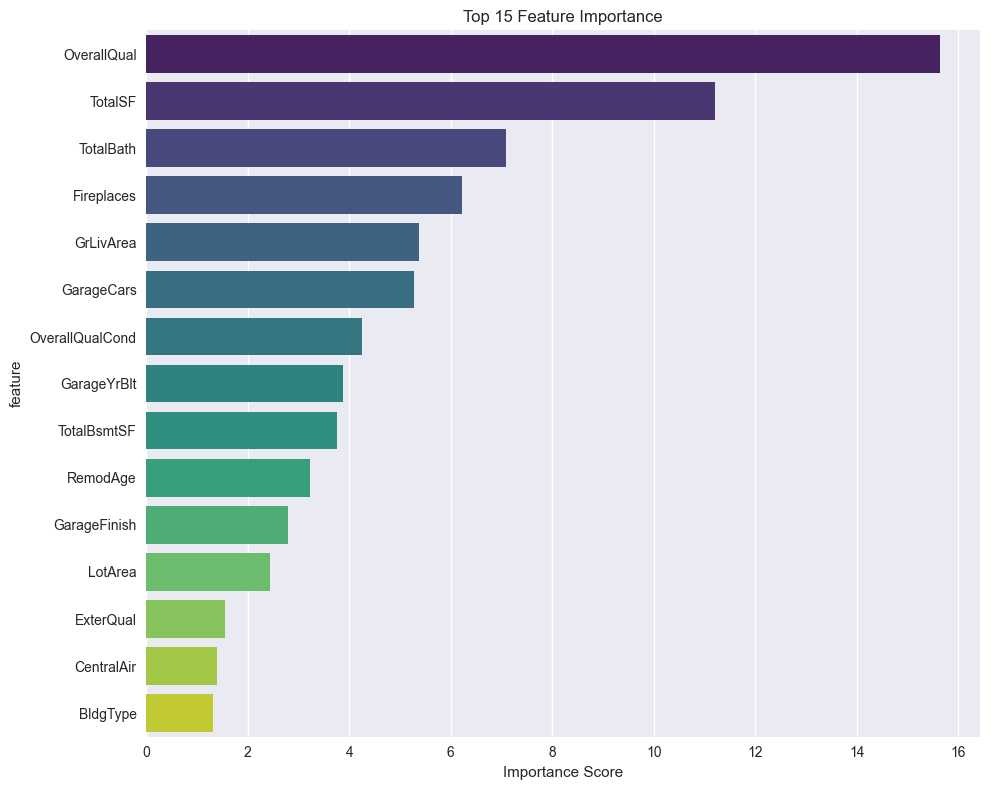

In [7]:
best_model_name = model_comparison.iloc[0]['Model']
print(f"Best performing model: {best_model_name}")

if best_model_name == 'XGBoost':
    print("Tuning XGBoost hyperparameters...")
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    }
    xgb_tuned = xgb.XGBRegressor(random_state=42)
    grid_search = GridSearchCV(xgb_tuned, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_xgb = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
    final_model, _, _ = evaluate_model(best_xgb, X_train, y_train, X_val, y_val, 'Tuned XGBoost')
else:
    final_model = models[best_model_name]

# Feature importance
if hasattr(final_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Top 15 most important features:")
    print(feature_importance.head(15))
    
    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_importance.head(15), x='importance', y='feature', palette='viridis')
    plt.title('Top 15 Feature Importance')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()


## Final Predictions

Submission file created: submission.csv
Best Model: CatBoost
Final Cross-Validation RMSE: 0.1292
Number of features used: 86
Training samples: 1168
Validation samples: 292


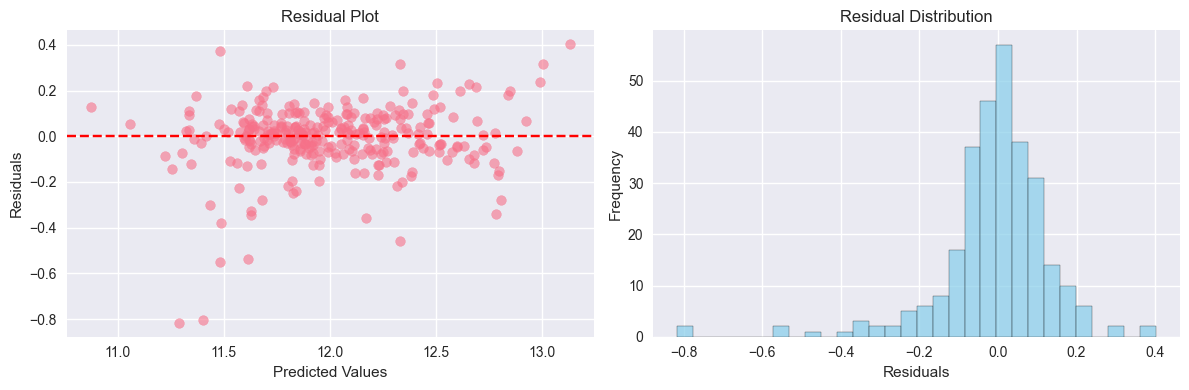

In [8]:
# Prepare test features
X_test = test_data.drop(['Id'], axis=1)

# Predict
if best_model_name in ['Linear Regression', 'Ridge', 'Lasso']:
    X_test_scaled = scaler.transform(X_test)
    y_pred_log = final_model.predict(X_test_scaled)
else:
    y_pred_log = final_model.predict(X_test)

y_pred = np.expm1(y_pred_log)

submission = pd.DataFrame({
    'Id': test_data['Id'],
    'SalePrice': y_pred
})
submission.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")

# Final summary
print(f"Best Model: {best_model_name}")
print(f"Final Cross-Validation RMSE: {model_comparison.iloc[0]['CV RMSE']:.4f}")
print(f"Number of features used: {len(X.columns)}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

# Residual analysis
y_pred_val = final_model.predict(X_val_scaled if best_model_name in ['Linear Regression', 'Ridge', 'Lasso'] else X_val)
residuals = y_val - y_pred_val

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(y_pred_val, residuals, alpha=0.6)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.tight_layout()
plt.show()

